In [34]:
import tensorflow as tf

In [35]:
import numpy as np

In [36]:
import pandas as pd

In [37]:
from IPython.display import Image

In [38]:
import os
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from pathlib import Path

## Dive into the data

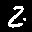

In [84]:
Image(filename = "test_data/id_10_label_5.png", width = 32, height = 32)

## A look at the folder content

In [85]:
directory = "./train_data"
images = os.listdir(directory)[0:12]

In [86]:
images

['id_2207_label_24.png',
 'id_3835_label_4.png',
 'id_11339_label_18.png',
 'id_13198_label_26.png',
 'id_3256_label_15.png',
 'id_40_label_5.png',
 'id_4101_label_9.png',
 'id_7121_label_23.png',
 'id_4808_label_13.png',
 'id_3739_label_20.png',
 'id_10171_label_12.png',
 'id_154_label_20.png']

## Displaying the data

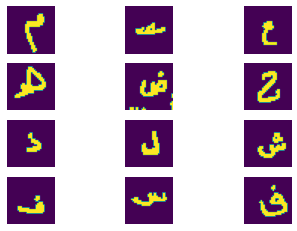

In [87]:
thumbs = [plt.imread(os.path.join(directory,i)) for x, i in enumerate(images)]

fig, axes = plt.subplots(4, 3, sharex=True, sharey=True) 

for img, ax in zip(thumbs, axes.flat):
    ax.imshow(img)
    ax.axis('off')

## Define the data dictionary

In [89]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [91]:
arabic_char_utf8 = ("أ","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي")

In [90]:
len(arabic_characters)

28

In [17]:
arabic_characters[12]

'sheen'

In [92]:
arabic_char_utf8[12]

'ش'

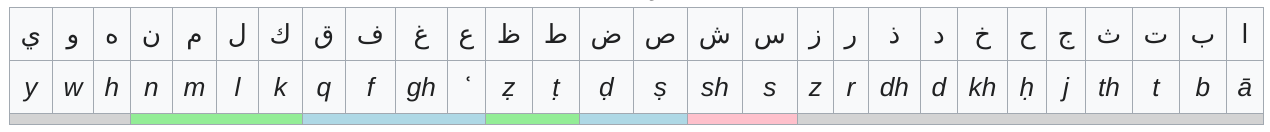

In [128]:
batch_size = 32
img_height = 32
img_width = 32

def get_dataset(dataset_dir):
    
    def process_filename(file_path):
        label = tf.strings.regex_replace(input=file_path,pattern=r".+_label_(\d+)\.png", rewrite=r"\1")
        label = tf.strings.to_number(label, tf.int32)
        #label = tf.one_hot(label, depth=29)
        return label

    def process_img(file_path):

        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=0)
        img = tf.image.resize(img, size=(32, 32))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255.0
        #img = tf.image.rgb_to_grayscale(img)
        #img = tf.image.convert_image_dtype(img, tf.float32)
        #img = tf.image.resize(img, size=(32, 32))
        return img
    
    data_dir = pathlib.Path(dataset_dir)
    file_list = [str(path.absolute()) for path in Path(data_dir).glob("*.png")]
    files_ds = tf.data.Dataset.from_tensor_slices((file_list))
    files_ds = files_ds.map(lambda x: (process_img(x), process_filename(x)))
    return files_ds

In [129]:
train_dataset_path = "train_data"
test_dataset_path = "test_data"

train_ds = get_dataset(train_dataset_path).shuffle(buffer_size=batch_size * 10).batch(batch_size)
valid_ds = get_dataset(test_dataset_path).batch(batch_size)

In [130]:
model = tf.keras.Sequential([
    # Convert the 28x28 image into a flat vector of 28x28 = 784 values
    tf.keras.layers.Flatten(input_shape=(32, 32), name='flatten_input'),
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 29 neurons
    tf.keras.layers.Dense(29, name='hidden_to_logits'),
])

In [131]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (Flatten)      (None, 1024)              0         
_________________________________________________________________
input_to_hidden1 (Dense)     (None, 256)               262400    
_________________________________________________________________
hidden1_to_hidden2 (Dense)   (None, 128)               32896     
_________________________________________________________________
hidden_to_logits (Dense)     (None, 29)                3741      
Total params: 299,037
Trainable params: 299,037
Non-trainable params: 0
_________________________________________________________________


In [121]:
optimizer = tf.keras.optimizers.Adam(lr=1E-3)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [122]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [123]:
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [124]:
num_epochs = 50  # The number of epochs to run

# Lists to store the loss and accuracy of every epoch
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [125]:
# Defined a function to train the model using tf.GradientTape
@tf.function
def train_step(image, label):
  # Initialise a GradientTape to track the operations
  with tf.GradientTape() as tape:
    # Compute the logits (un-normalised scores) of the current batch of examples
    # using the neural network architecture we defined earlier
    logits = model(image)
    loss = loss_object(label, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  # Add current batch loss to our loss metric tracker - note the function call semantics
  train_loss(loss)
  train_accuracy(label, logits)

In [126]:
@tf.function
def valid_step(image, label):
    valid_logits = model(image, training=False)
    valid_accuracy(label, valid_logits)
    loss = loss_object(label, valid_logits)
    valid_loss(loss)

In [127]:
for epoch in range(num_epochs):
  # Loop over our data pipeline
  for image, label in train_ds:
    train_step(image, label)

  for image, label in valid_ds:
    valid_step(image, label)
    
  template = 'Epoch {:03d}, Train Loss: {:.3f}, Train Accuracy: {:.3%}, Valid Loss: {:.3f}, Valid Accuracy: {:.3%}'
  print(template.format(epoch+1,
                        train_loss.result(), 
                        train_accuracy.result(),
                        valid_loss.result(),
                        valid_accuracy.result(),
                       ))
  
  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  valid_losses.append(valid_loss.result())
  valid_accuracies.append(valid_accuracy.result())

Epoch 001, Train Loss: 1.348, Train Accuracy: 57.448%, Valid Loss: 1.142, Valid Accuracy: 63.304%
Epoch 002, Train Loss: 1.098, Train Accuracy: 65.238%, Valid Loss: 1.049, Valid Accuracy: 66.057%
Epoch 003, Train Loss: 0.931, Train Accuracy: 70.298%, Valid Loss: 0.992, Valid Accuracy: 67.609%
Epoch 004, Train Loss: 0.806, Train Accuracy: 74.321%, Valid Loss: 0.950, Valid Accuracy: 69.048%
Epoch 005, Train Loss: 0.710, Train Accuracy: 77.387%, Valid Loss: 0.921, Valid Accuracy: 70.083%
Epoch 006, Train Loss: 0.631, Train Accuracy: 79.926%, Valid Loss: 0.912, Valid Accuracy: 70.863%
Epoch 007, Train Loss: 0.565, Train Accuracy: 82.078%, Valid Loss: 0.905, Valid Accuracy: 71.446%
Epoch 008, Train Loss: 0.512, Train Accuracy: 83.800%, Valid Loss: 0.904, Valid Accuracy: 71.923%
Epoch 009, Train Loss: 0.467, Train Accuracy: 85.264%, Valid Loss: 0.914, Valid Accuracy: 72.169%
Epoch 010, Train Loss: 0.431, Train Accuracy: 86.442%, Valid Loss: 0.922, Valid Accuracy: 72.551%
Epoch 011, Train Los

In [ ]:
# Plot the loss for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), valid_losses)
plt.title('Loss vs epochs')

# Plot the accuracy for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_accuracies)
plt.plot(range(num_epochs), valid_accuracies)
plt.title('Accuracy vs epochs')

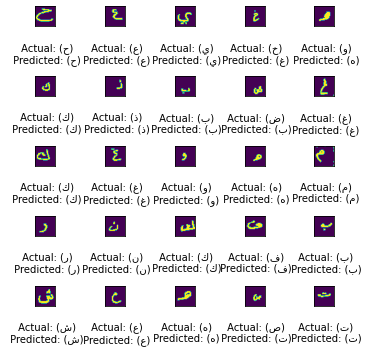

In [105]:
images, labels = next(iter(valid_ds))
_logits = model(images, training=False)
predicted_labels = tf.argmax(_logits, axis=1, output_type=tf.int32)
img_indexs = np.arange(images.numpy().shape[0])
np.random.shuffle(img_indexs)

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)

    img_index = img_indexs[i]
    predicted_label = int(predicted_labels[img_index])

    plt.imshow(images[img_index])

    actual_label = int(labels[img_index].numpy())
    plt.xlabel("\n Actual: ({})\n Predicted: ({})".format(
        arabic_char_utf8[actual_label-1],  arabic_char_utf8[predicted_label-1]
    ))

plt.tight_layout()
plt.show()